<a href="https://colab.research.google.com/github/dolmaenghee/team_D/blob/main/Week2_Group_Quiz_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import modules

- Runtime -> GPU로 바꿀것

In [88]:
from re import M
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import torchvision as tv
import matplotlib.pyplot as plt
import torch.optim as optim

%matplotlib inline

In [89]:
#Hyperparameters setting
LR = 0.1
EPOCHS = 10 # 빠른 Training과정 확인을 위해 10으로 Setting 하였습니다. 원본 코드는 100
BATCHSIZE = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [90]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        computation_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {computation_time} seconds")
        return result
    return wrapper

## Dataset/DataLoader

In [91]:
train_dataset = tv.datasets.MNIST(".", download=True, train=True, transform=tv.transforms.ToTensor()) #transform = torchvision.transforms.ToTensor() 로 불러올 때 부터 텐서 형식으로 변환해 불러옵니다.
test_dataset = tv.datasets.MNIST(".", download=True, train=False, transform=tv.transforms.ToTensor())

In [92]:
print("Image Type >> {}\nShape of Image >> {}\nClass >> {}".format(train_dataset[0][0].dtype,train_dataset[0][0].shape, train_dataset[0][1]))

Image Type >> torch.float32
Shape of Image >> torch.Size([1, 28, 28])
Class >> 5


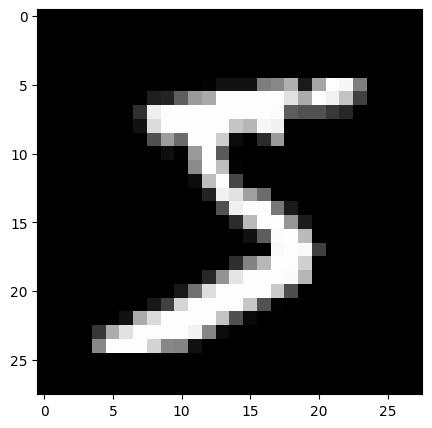

In [93]:
plt.figure(figsize=(5,5))
plt.imshow(train_dataset[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [94]:
from torch.utils.data.dataloader import DataLoader
np.random.seed(42)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCHSIZE, shuffle=True) #Shuffle 을 진행하지만 동일한 데이터가 각 batch 내에서 겹치지 않도록 불러옵니다.
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCHSIZE, shuffle=False)

In [95]:
img, class_num = next(iter(train_loader)) #원래사이즈 (1,28,28) -> [BATCHSIZE, 1, 28, 28] class_num 역시 (1) -> [BATCHSIZE]
print(img.shape, class_num.shape)

torch.Size([512, 1, 28, 28]) torch.Size([512])


## Model Construction

In [96]:
class DeepClassification(nn.Module):
    def __init__(self, hidden_variables=[128, 64, 10], input_output_dim=(28*28, 10)):
        super().__init__()
        # Concise Implementation
        self.input_variable_dim = input_output_dim[0]
        self.output_variable_dim = input_output_dim[1]
        self.list_hidden_variable = hidden_variables
        self.layer = nn.Sequential()

        variable_dim = self.input_variable_dim
        for i, hidden_variable in enumerate(self.list_hidden_variable):
            self.layer.add_module('layer_' + str(i), nn.Linear(variable_dim, hidden_variable))
            self.layer.add_module('activation_' + str(i), nn.ReLU())
            variable_dim = hidden_variable
        self.layer.add_module('final_layer', nn.Linear(variable_dim, self.output_variable_dim))

    def forward(self, x):
    # Computes the outputs / predictions
        x = x.view(-1, 28*28)
        y_hat = self.layer(x)
        return y_hat

In [97]:
model = DeepClassification().to(device)

In [98]:
#! pip install torchsummary
from torchsummary import summary

summary(model, input_size = (BATCHSIZE,1,28,28)) #torch summary 모듈 이용하시면 Keras처럼 정리해서 볼 수 있어요.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
              ReLU-6                   [-1, 10]               0
            Linear-7                   [-1, 10]             110
Total params: 109,496
Trainable params: 109,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.53
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 1.95
----------------------------------------------------------------


In [99]:
loss_fn = nn.CrossEntropyLoss() #Loss 함수 정의
optimizer = optim.SGD(model.parameters(), lr=LR) #optimizer 정의

#Dataloader를 사용했으므로 Minibatch SGD!

In [100]:
def make_train_step(model, loss_fn, optimizer):
    def train_step_fn(x, y):

        model.train()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        return loss.item()
    return train_step_fn

In [101]:
train_step = make_train_step(model, loss_fn, optimizer)

In [102]:
from tqdm import tqdm # for문과 같은 반복문에 사용되는 iterable 객체에 씌워주면 한 번 for문이 돌아갈 때, 시간계산해서 예상 시간과 진척도를 보여줍니다.

def evaluate_step(x, y):
    y_hat = model(x)
    result = torch.sum(torch.argmax(y_hat, axis=1) == y) #argmax(y_hat, axis = 1) <= model forwardpass에서 나온 [512, 10] 결과물 에서 axis 1 (10)을 기준으로 가장 큰 값을 뽑아냅니다. 10개의 Class중 가장 확률이 높은걸 가져온다고 보면 됩니다.
    return result, len(y)

@timer
def train_model_classification(epochs=1000, eval_test_accuracy=False):
    train_losses = []
    for epoch in tqdm(range(epochs)): #이렇게 기존 for문에서 tqdm을 둘러준 것 만으로 진척도 확인이 가능!
        mini_batch_losses = []
        for x_minibatch, y_minibatch in train_loader:
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)
            mini_batch_loss = train_step(x_minibatch, y_minibatch)
            mini_batch_losses.append(mini_batch_loss)

        # Evaluate train loss
        if (epoch + 1) % 10 == 0:
            loss = np.mean(mini_batch_losses)
            print("train loss at {} epoch:{}".format(epoch + 1, loss))
            train_losses.append(loss)

    # 여기 이미 교수님께서 구현을 해놓으셨더군요
    if eval_test_accuracy:
        # Evaluate test accuracy
        with torch.no_grad():
            test_accuracy = 0
            test_result = 0
            test_cnt = 0
            for x_minibatch_test, y_minibatch_test in test_loader:
                x_minibatch_test = x_minibatch_test.to(device)
                y_minibatch_test = y_minibatch_test.to(device)
                result, cnt = evaluate_step(x_minibatch_test, y_minibatch_test)
                test_result += result
                test_cnt += cnt
            test_accuracy = 100 * test_result / test_cnt
            print("test accuracy: {}%".format(test_accuracy))

    return train_losses, test_accuracy

## Train and Evaluate

In [103]:
train_loss, test_accuracy = train_model_classification(epochs=EPOCHS, eval_test_accuracy=True) #실험용 epoch 10으로 설정

100%|██████████| 10/10 [01:22<00:00,  8.22s/it]

train loss at 10 epoch:0.17400439557130054


test accuracy: 92.63999938964844%
Execution time of train_model_classification: 83.5200080871582 seconds


In [104]:
#save checkpoint

checkpoint = {'epochs':EPOCHS,
              'model_state_dict':model.state_dict(),
              'optimizer_state_dict':optimizer.state_dict(),
              'train_loss':train_loss,
              'test_accuracy':test_accuracy}

torch.save(checkpoint, 'model_checkpoint.pth')

#load checkpoint

checkpoint = torch.load('model_checkpoint.pth')
# Load model parameters
model = DeepClassification().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# Load optimizer parameters
optimizer = optim.SGD(model.parameters(), lr=LR)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [105]:
print('epochs :: {}'.format(checkpoint['epochs']))
print('model_state_dict :: {}'.format(checkpoint['model_state_dict'].keys()))
print('optimizer_state_dict :: {}'.format(checkpoint['optimizer_state_dict']))
print('train_loss :: {}'.format(checkpoint['train_loss'][0]))
print('test_accuracy :: {}%'.format(checkpoint['test_accuracy']))

epochs :: 10
model_state_dict :: odict_keys(['layer.layer_0.weight', 'layer.layer_0.bias', 'layer.layer_1.weight', 'layer.layer_1.bias', 'layer.layer_2.weight', 'layer.layer_2.bias', 'layer.final_layer.weight', 'layer.final_layer.bias'])
optimizer_state_dict :: {'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}, 3: {'momentum_buffer': None}, 4: {'momentum_buffer': None}, 5: {'momentum_buffer': None}, 6: {'momentum_buffer': None}, 7: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}
train_loss :: 0.17400439557130054
test_accuracy :: 92.63999938964844%
